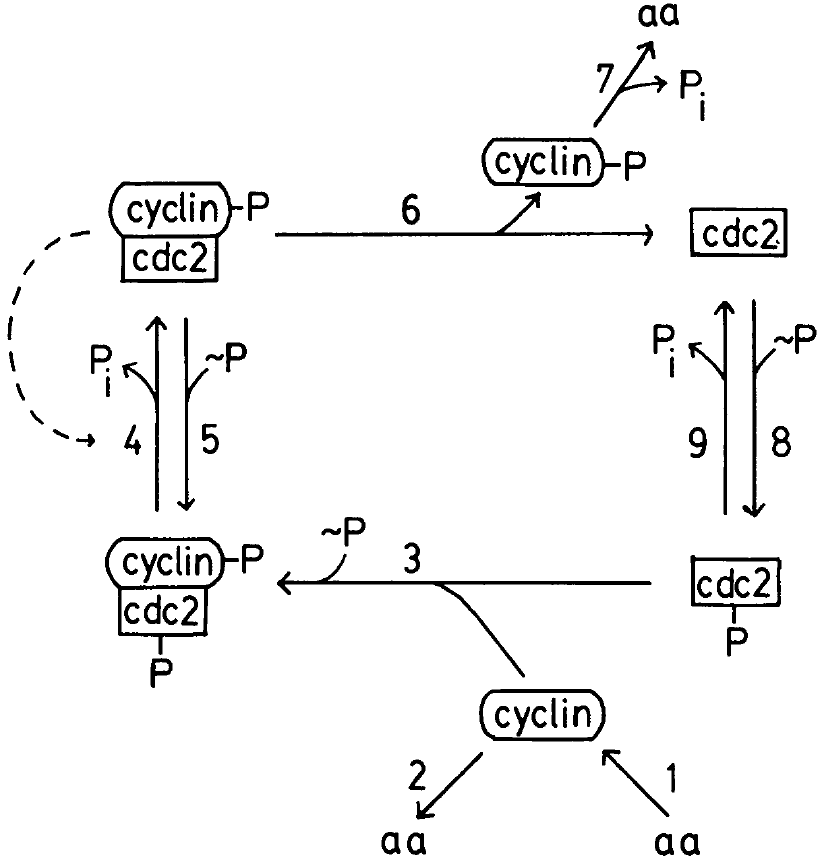

In [2]:
from IPython.display import Image
Image(filename='TysonGraph.png')

1)Import all features from pysb

In [3]:
from pysb import *

2) Import pysb macros

In [4]:
from pysb.macros import *

3) Import Avogadro's number to convert parameter rates

In [5]:
from scipy.constants import N_A

4) Generate instance of model class

In [6]:
Model()

<Model '_interactive_' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0) at 0x1112e7940>

5) Define two monomers:
* cyclin that has two sites. One of the sites is the binding site and the oter site is the phoshorilation one. The    phosphorilation site has two states: phosphorilated and unphosphorilated.
* cdc2 that has two sites. One of the sites is the binding site and the oter site is the phoshorilation one. The    phosphorilation site has two states: phosphorilated and unphosphorilated.


In [7]:
Monomer('cyclin', ['Y', 'b'], {'Y': ['U','P']})
Monomer('cdc2', ['Y', 'b'], {'Y': ['U','P']})

Monomer('cdc2', ['Y', 'b'], {'Y': ['U', 'P']})

In [8]:
VOL = 1e-20
NA_V = N_A*VOL

Parameter('k1', 0.015*NA_V)
Parameter('k2', 0)
Parameter('k3', 200/NA_V)
Parameter('k4', 2*180/NA_V/NA_V)
Parameter('kp4', 0.018)
Parameter('k5', 0)
Parameter('k6', 1.0)
Parameter('k7', 0.6)
Parameter('k8', 1e6)
Parameter('k9', 1e3)

Parameter('k9', 1000.0)

Use the synthesise function to create cyclin in state unbounded and unphosphorilated. synthesize(species, k_synthesis)

In [9]:
synthesize(cyclin(Y='U', b=None), k1)

ComponentSet([
 Rule('synthesize_cyclinU', None >> cyclin(Y='U', b=None), k1),
 ])

Create a binding and  phosphorilation rule. Cyclin combines with cdc2-P (step 3) to form Cyclin%cdc2-p. "At some point after heterodimer formation, the cyclin subunit is phosphorylated. (Assuming phosphorylation is faster than dimerization, I write the two-step process as a single step, rate-limited by dimerization.)" J. J. Tyson, PNAS (1991) 7328-7332

In [10]:
Rule('BindingAndPhosphoylation', cyclin(Y='U', b=None) + 
     cdc2(Y='P', b=None) >> 
     cyclin(Y='P', b=1) % cdc2(Y='P', b=1), k3)

Rule('BindingAndPhosphoylation', cyclin(Y='U', b=None) + cdc2(Y='P', b=None) >> cyclin(Y='P', b=1) % cdc2(Y='P', b=1), k3)

cyclin(Y='P', b=1) % cdc2(Y='U', b=1) is generated in an autocatalytic fashion 

In [11]:
Rule('Activation', cyclin(Y='P', b=1) % cdc2(Y='P', b=1) >> 
     cyclin(Y='P', b=1) % cdc2(Y='U', b=1), kp4)

Rule('Activation', cyclin(Y='P', b=1) % cdc2(Y='P', b=1) >> cyclin(Y='P', b=1) % cdc2(Y='U', b=1), kp4)

In [12]:
Rule('Autocatalytic', cyclin(Y='P', b=1) % cdc2(Y='P', b=1) +
     cyclin(Y='P', b=2) % cdc2(Y='U', b=2) +
     cyclin(Y='P', b=2) % cdc2(Y='U', b=2) >>
cyclin(Y='P', b=1) % cdc2(Y='U', b=1) +
     cyclin(Y='P', b=2) % cdc2(Y='U', b=2) +
     cyclin(Y='P', b=2) % cdc2(Y='U', b=2), k4)

Rule('Autocatalytic', cyclin(Y='P', b=1) % cdc2(Y='P', b=1) + cyclin(Y='P', b=2) % cdc2(Y='U', b=2) + cyclin(Y='P', b=2) % cdc2(Y='U', b=2) >> cyclin(Y='P', b=1) % cdc2(Y='U', b=1) + cyclin(Y='P', b=2) % cdc2(Y='U', b=2) + cyclin(Y='P', b=2) % cdc2(Y='U', b=2), k4)

cyclin(Y='P', b=1) % cdc2(Y='U', b=1) is dissociated

In [13]:
Rule('Dissociation', cyclin(Y='P', b=1) % cdc2(Y='U', b=1) >>
     cdc2(Y='U', b=None), k6)

Rule('Dissociation', cyclin(Y='P', b=1) % cdc2(Y='U', b=1) >> cdc2(Y='U', b=None), k6)

Cdc2-U and Cdc2-P equilibrate. You can use the equilibrate function from macros: equilibrate(protein1, protein2, [list_rate_parameters])

In [14]:
equilibrate(cdc2(Y='U', b=None), cdc2(Y='P', b=None), [k8, k9])

ComponentSet([
 Rule('equilibrate_cdc2U_to_cdc2P', cdc2(Y='U', b=None) | cdc2(Y='P', b=None), k8, k9),
 ])

Declare initial conditions

In [15]:
#Initial conditions
Parameter("cdc_0", 1 * NA_V)
Initial(cdc2(Y='P', b=None), cdc_0)

# [Y] in Tyson
Parameter('cyc_0', 0.25 * NA_V)
Initial(cyclin(Y='U', b=None), cyc_0)

Declare an observable for total cyclin and  the Cyclin-P%Cdc2-U complex

In [16]:
Observable('total_cyclin', cyclin()) 
Observable('active_cyclin', cyclin(b=1, Y='P') % cdc2(b=1, Y='U')) 

Observable('active_cyclin', cyclin(Y='P', b=1) % cdc2(Y='U', b=1))

Simulation

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


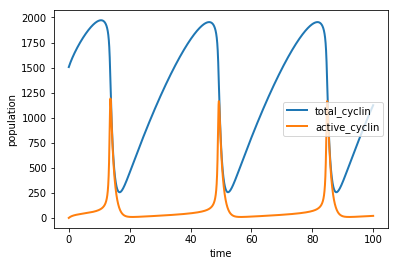

In [17]:
%matplotlib inline
from pysb.integrate import odesolve
from numpy import *
import matplotlib.pyplot as plt

t = linspace(0, 100, 10001)
x = odesolve(model, t)

plt.plot(t, x['total_cyclin'], lw=2, label='total_cyclin')
plt.plot(t, x['active_cyclin'], lw=2, label='active_cyclin')

plt.legend(loc=0)
plt.xlabel('time')
plt.ylabel('population')

plt.show()